Import the necessary packages:
- matplotlib.pyplot: to plot the diagrams when needed
- numpy: we will be working with numpy arrays to be compatible with numba (in case it's needed).
- from scipy.special: binom, factorial, functions to calculate binomial and factorial.

In [491]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom, factorial

### Some useful functions

For the later functions, there will be some functions that will be useful for different reasons.
- `trim_zeros`: there are 2 functions, one for the 2D arrays, and another for the 3D arrays

In [ ]:
def trim_zeros_2D(array):
    # Identify rows and columns that contain only zeros
    non_zero_rows = ~np.all(array == 0, axis=1)
    non_zero_cols = ~np.all(array == 0, axis=0)

    # Filter the array to include only rows and columns with non-zero values
    trimmed_array = array[non_zero_rows][:, non_zero_cols]
    return trimmed_array
    
def trim_zeros_3D(array):
    # Create a mask to identify non-zero elements along each dimension
    mask = ~(array == 0).all(axis=(1, 2))
    trimmed_array = array[mask]
    
    mask = ~(trimmed_array == 0).all(axis=(0, 2))
    trimmed_array = trimmed_array[:, mask]
    
    mask = ~(trimmed_array == 0).all(axis=(0, 1))
    trimmed_array = trimmed_array[:, :, mask]
    
    return trimmed_array

### Defining the Diagram

To define a diagram in terms of numpy arrays, we will need at least 2 arrays:

- points: contains the coordinates in the 2D plane where a "connection" can be produced. In general any type of particles could be connected to those points.
- paths: contains the ways the points are connected. For that, we indicate the position in the points array of the start and the end of the line/path. This will be the way we differentiate between the different types of particles.

Then for the simplest case there will be a single paths array, but when more than one type of particle is considered, there will be more than one paths array, one for each type of particle, e.g. if we consider quarks and gluons, then there will be paths_quark, and paths_gluon.

(In the future, all this should be implemented as attributes of a class, but let's consider them separately for now)

Let's start by the simplest case, the diagrams for the 1st order in gluons.

In [492]:
points_1st_1 = np.array([[0, 1], [0, 3], [1, 2], [2, 2]])
paths_1st_1 = np.array([[1, 3], [2, 3], [3, 4]]) 

points_1st_2 = np.array([[0, 2], [1, 2], [2, 1], [2, 3]])
paths_1st_2 = np.array([[1, 2], [2, 3], [2, 4]]) 

### Represent the Diagram
To represent the diagram we define a function that takes the 2 previous array and outputs the diagram.

Where the optional arguments implies:
- `index` (default = False): to show the indices for the points in the diagram
- `directory`: if indicated a directory the plot will be saved in that location instead of showed.
- `colors` (default = 'tab:blue'): to indicate the color of the lines.
- `number`: added to indicate the number of similar diagrams obtained during the calculation.

**We have to be careful with loops**:
There's the function `find_equal_subarrays` that detects if in the path array there are 2 subarrays that have the same 2 points, in which case indicate a loop, and it output a 2D array with the position in the path array where the loop happens.


In [ ]:
def find_equal_subarrays(array):
    sorted_subarrays = [np.sort(subarray) for subarray in array]
    unique_subarrays, indices, counts = np.unique(sorted_subarrays, axis=0, return_index=True, return_counts=True)
    duplicate_positions = [np.where((sorted_subarrays == unique_subarrays[i]).all(axis=1))[0] for i in range(len(unique_subarrays)) if counts[i] > 1]
    return duplicate_positions

def represent_diagram (points, paths, index = False, directory = "", colors = "tab:blue", number = 0):
    fig=plt.figure(figsize=(5,3)) 
    ax=fig.add_subplot(111)
    ax.axis('off')
    paths = trim_zeros_2D(paths)
    points = trim_zeros_2D(points)

    loops = find_equal_subarrays(paths)
    
    for i in range(len(paths)):
        if np.isin(i, loops):
            middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
            circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors, fill=False)
            ax.add_patch(circle)
        else:
            ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors)
    if index:
        for i in range(np.max(paths)):
            ax.text(points[i, 0], points[i, 1], str(i+1), fontsize=12, color="black", ha="right", va="top")
    if number !=0:
        ax.text(0.5, 0.5, f"N = {number}", fontsize=12, color="black", ha="center", va="center")
    if directory != "":
        plt.savefig(directory, bbox_inches='tight')
        plt.close()

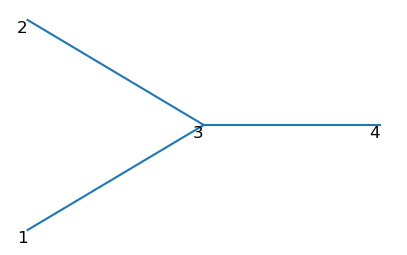

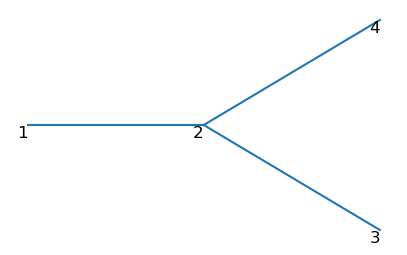

In [494]:
represent_diagram(points_1st_1, paths_1st_1, index = True)
represent_diagram(points_1st_2, paths_1st_2, index = True)

### Input/Output particles

Later to make easier some calculus, it's useful to identify the input paths/particles and output paths/particles.

For it let's define the functions `in_out_paths`, that given the paths return a 2D array with the input and output points, of the form:
```
[[array of input points], [array of output points]]
```

Also here are some functions that trims the 0 out of an array when all subarrays in it are 0, for 2D and 3D array, these are used in `in_out_paths`, and many future functions.

In [495]:
def in_out_paths (paths):
    in_out_paths = np.zeros((2, len(paths)), dtype=int)
    inp = 0
    out = 0
    #iterate over all points (from 1 to the maximum point number)
    for i in range(1, np.max(paths)+1):
        count = 0
        input = False
        #iterate over all paths to find the points that appear only once.
        #if the point appears in the first column of a path, it is an output.
        #if the point appears in the second column of a path, it is an input.
        for j in range(len(paths)):
            for k in range(2):
                if paths[j, k] == i:
                    count += 1
                    if k == 1:
                        input = True
                    if count > 1:
                        break
        if count == 1:
            if input:
                in_out_paths[0,inp] = i
                inp += 1
            else:
                in_out_paths[1,out] = i
                out += 1
    return in_out_paths

In [496]:
print(in_out_paths(paths_1st_1))
print(in_out_paths(paths_1st_2))

[[4 0 0]
 [1 2 0]]
[[3 4 0]
 [1 0 0]]


### Product of 2 diagrams

The number of new diagrams can be determined by the expresion:

\begin{equation}
    S = \sum_{i=1}^{N} n_i, \,\, \text{with,    } n_i = \binom{n_1}{i} \binom{n_2}{i} i!
\end{equation}

$n_1$ is the number of input particles from diagram 1, and $n_2$ is the number of output particles from diagram 2. N is the maximum number of connections possible,

$$
    N = min(n_1, n_2)
$$

After knowing the number of new diagrams to calculate, we consider the particles to connect in each case and output the points and paths.

The function `how_connected`given the number of the input and output particles to connect $n_1, n_2$, the number of new diagrams determined by the expression above, and the maximum number of connections possible $N$. Returns an array with the combinations of points from the inputs and outputs for the function `connection` to connect.


In [497]:
def connection(points1, paths1, points2, paths2, offset = 0):

    in_out_paths1 = in_out_paths(paths1)
    in_out_paths2 = in_out_paths(paths2)

    #Create the new points array
    points = np.zeros((len(points1) + len(points2), 2))
    points[:len(points1)] = points1
    points[len(points1):] = points2 + np.array([np.max(points1)+1, offset])

    for i in range(len(in_out_paths2)):
        for j in range(len(in_out_paths2[0])):
            if in_out_paths2[i, j] != 0:
                in_out_paths2[i, j] += len(points1)

    #Calculate the number of connections
    n_1 = len(np.trim_zeros(in_out_paths1[0]))
    n_2 = len(np.trim_zeros(in_out_paths2[1]))
    max_connections = min(n_1, n_2)

    n_connections = 0
    for i in range (max_connections):
        n_connections += int(binom(n_1, i+1)*binom(n_2, i+1) * factorial(i+1))

    combinations = how_connected(max_connections, n_connections, n_1, n_2)
    combinations = trim_zeros_3D(combinations)
    n  = len(combinations)
    n_paths = len(combinations[0])
    paths = np.zeros((n, len(paths1) + len(paths2) + n_paths, 2), dtype=int)
    paths[:n, :len(paths1)] = paths1

    for i in range(n):
        for j in range(n_paths):
            if (combinations[i, j, 0] != 0 and combinations[i, j, 1] != 0):
                paths[i, len(paths1)+j] = np.array([in_out_paths1[0, combinations[i, j, 0]-1], in_out_paths2[1, combinations[i, j, 1]-1]])
        if (np.count_nonzero(paths2) != 0):
            for k in range(len(paths2)):
                if (paths2[k, 0] != 0 and paths2[k, 1] != 0):
                    paths[i, len(paths1)+n_paths+k] = paths2[k] + np.array([len(points1), len(points1)])

    return points, paths

def how_connected( max_connections, n_connections, n_1, n_2):
    combinations = np.zeros((n_connections, max_connections, 2), dtype=int)
    n = 0 
    while n < n_connections:
        for j in range (n_1):
            for k in range(n_2):
                combinations[n, 0] = np.array([j+1, k+1])
                n += 1
                if n == n_connections:
                    break
            if n == n_connections:
                break
            
    n = n_1*n_2
    if max_connections >1:
        while n < n_connections:
            diff = False
            i = 1
            while i < max_connections:  
                for j in range (n_1):
                    for k in range(n_2):
                        for l in range(i):
                            if (j+1) != combinations[n, l, 0] and (k+1) != combinations[n, l, 1]:
                                diff = True
                            else:
                                diff = False
                        if diff:
                            combinations[n, i] = np.array([j+1, k+1])
                            n +=1   
                        if n == n_connections:
                            return combinations      
                i += 1
    else:
        return combinations
        

#### Examples

Let's check that it's working with some examples

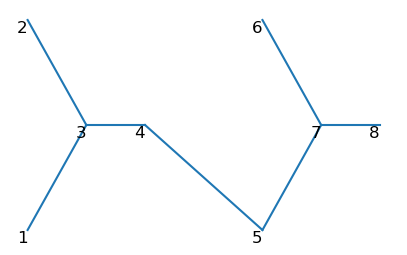

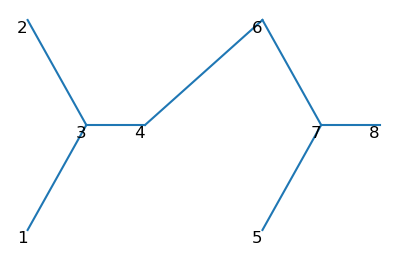

In [498]:
points_2nd_1, paths_2nd_1 = connection(points_1st_1, paths_1st_1, points_1st_1, paths_1st_1)

for i in range(len(paths_2nd_1)):
    represent_diagram(points_2nd_1, paths_2nd_1[i], index = True)

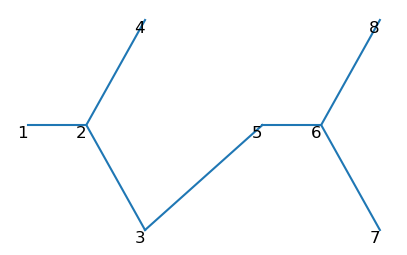

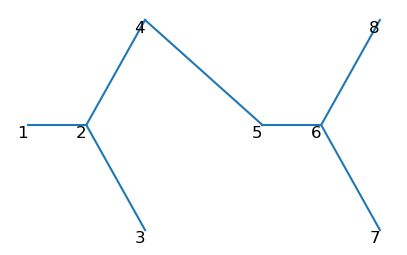

In [499]:
points_2nd_2, paths_2nd_2 = connection(points_1st_2, paths_1st_2, points_1st_2, paths_1st_2)

for i in range(len(paths_2nd_2)):
    represent_diagram(points_2nd_2, paths_2nd_2[i], index = True)

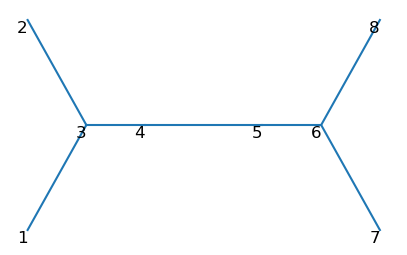

In [500]:
points_2nd_3, paths_2nd_3 = connection(points_1st_1, paths_1st_1, points_1st_2, paths_1st_2)

for i in range(len(paths_2nd_3)):
    represent_diagram(points_2nd_3, paths_2nd_3[i], index = True)

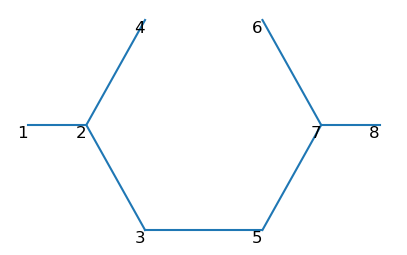

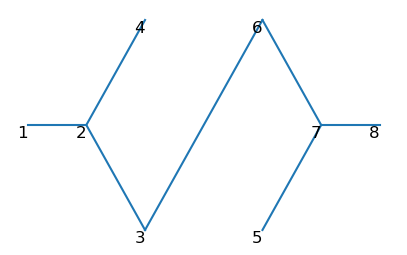

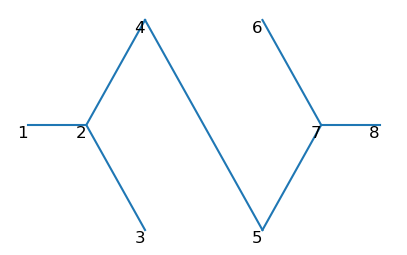

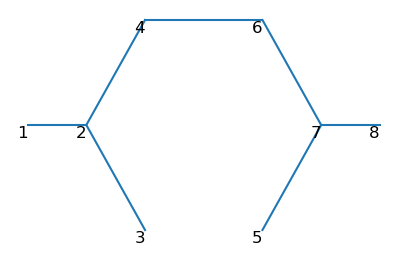

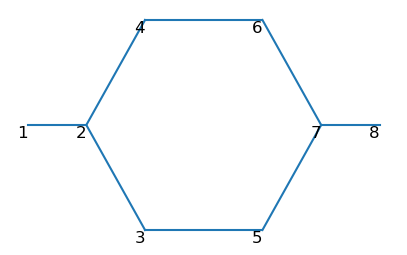

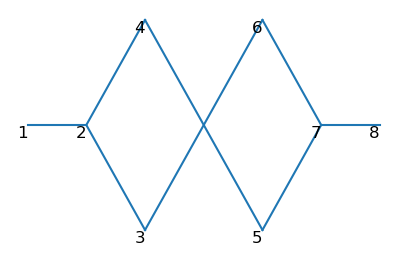

In [501]:
points_2nd_4, paths_2nd_4 = connection(points_1st_2, paths_1st_2, points_1st_1, paths_1st_1)

for i in range(len(paths_2nd_4)):
    represent_diagram(points_2nd_4, paths_2nd_4[i], index = True)

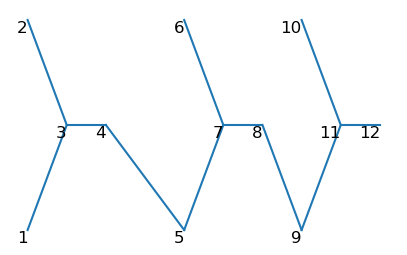

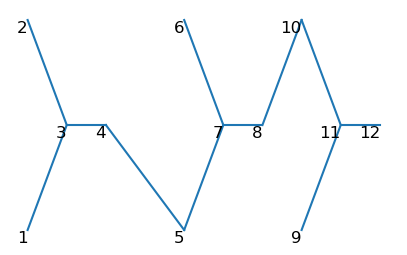

In [502]:
points_3rd_1, paths_3rd_1 = connection(points_2nd_1, paths_2nd_1[0], points_1st_1, paths_1st_1)

for i in range(len(paths_3rd_1)):
    represent_diagram(points_3rd_1, paths_3rd_1[i], index = True)

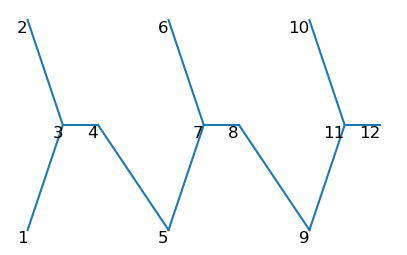

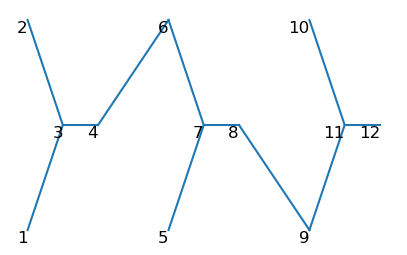

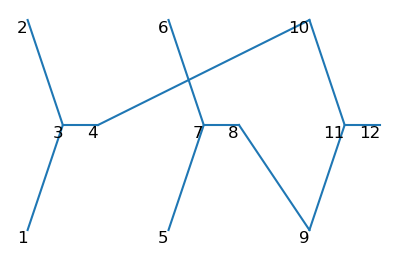

In [503]:
points_3rd_2, paths_3rd_2 = connection(points_1st_1, paths_1st_1, points_2nd_1, paths_2nd_1[0])

for i in range(len(paths_3rd_2)):
    represent_diagram(points_3rd_2, paths_3rd_2[i], index = True)

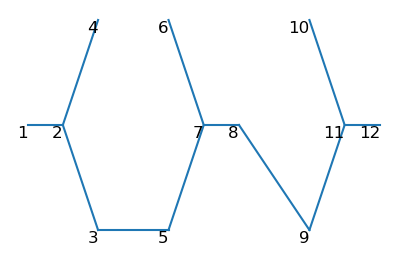

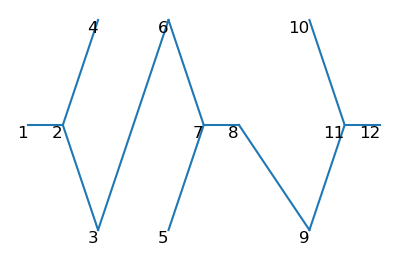

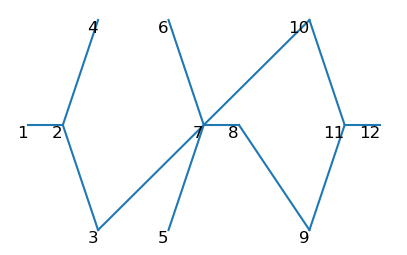

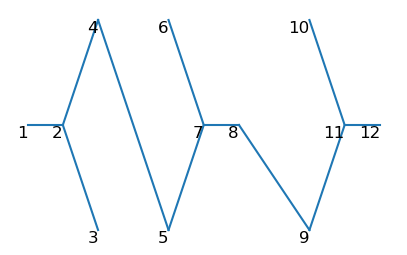

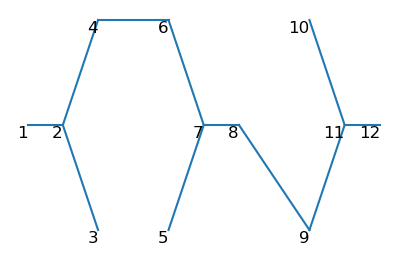

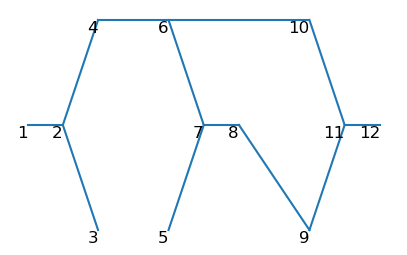

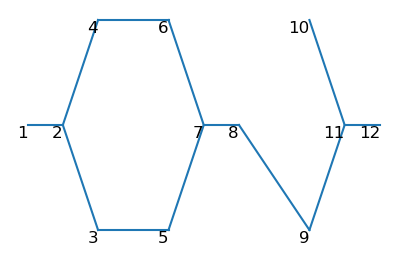

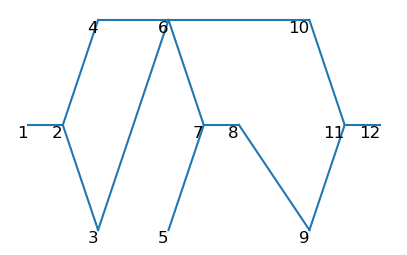

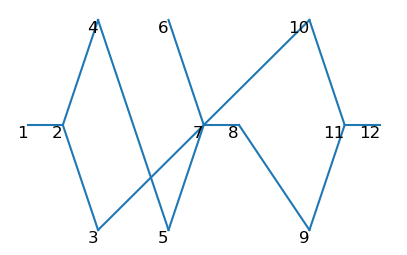

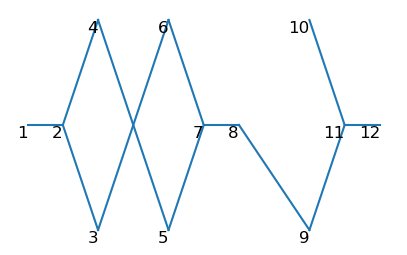

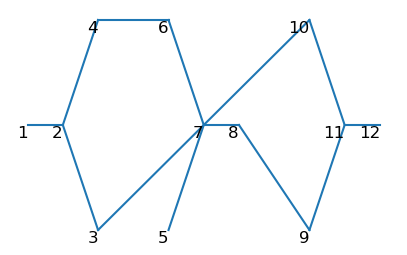

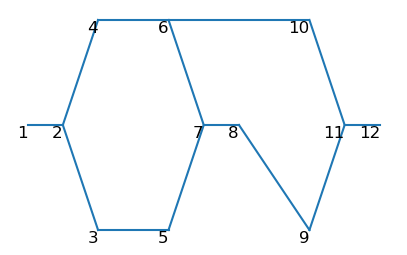

In [504]:
points_3rd_3, paths_3rd_3 = connection(points_1st_2, paths_1st_2, points_2nd_1, paths_2nd_1[0])

for i in range(len(paths_3rd_3)):
    represent_diagram(points_3rd_3, paths_3rd_3[i], index = True)

**Note: it seems that there are problems by superposition of lines, this should be get better (but not solved) by simplifiying the diagrams**

### Simplify Diagrams

As we have seen the diagrams from above have extra points, we want to simplify the diagrams by removing those unnecesary points. 

For it we find points that only have 2 connections, remove them, and modify the rest of points and paths to still indicate the same diagram.

In [505]:
def decrement_number_in_array(array, number):
    array[array == number] -= 1
    return array

def simplify_diagram_it(points, paths):
    pos = np.zeros((2, 2), dtype=int)
    for i in range(1, np.max(paths)+1):
        count = 0
        for j in range(len(paths)):
            for k in range(2):
                if paths[j, k] == i:
                    count += 1
                    if count == 1:
                        pos[0] = np.array([j, k])
                    elif count == 2:
                        pos[1] = np.array([j, k])
                    else:
                        break
        if count == 2:
            points = np.delete(points, i-1, axis=0)
            if pos[0, 1] == 0:
                if pos[1, 1] == 0:
                    prov = np.array([paths[pos[0, 0], 1], paths[pos[1, 0], 1]])
                elif pos[1, 1] == 1:
                    prov = np.array([paths[pos[0, 0], 1], paths[pos[1, 0], 0]])                   
            elif pos[0, 1] == 1:
                if pos[1, 1] == 0:
                    prov = np.array([paths[pos[0, 0], 0], paths[pos[1, 0], 1]])                  
                elif pos[1, 1] == 1:
                    prov = np.array([paths[pos[0, 0], 0], paths[pos[1, 0], 0]])
            paths = np.delete(paths, (pos[0, 0], pos[1, 0]), axis=0)
            paths = np.append(paths, [prov], axis=0)    
            for j in range (i, np.max(paths)+1):
                paths = decrement_number_in_array(paths, j)  
        
    for i in range(int(np.max(points, axis=0)[0])+1):
        count = 0
        for j in range(len(points)):
            if points[j, 0] == i:
                count +=1
                break
        if count == 0:
            for j in range(len(points)):
                if points[j, 0] > i:
                    points[j, 0] -= 1
    for i in range(1, int(np.max(points, axis=0)[1])+1):
        count = 0
        for j in range(len(points)):
            if points[j, 1] == i:
                count +=1
                break
        if count == 0:
            for j in range(len(points)):
                if points[j, 1] > i:
                    points[j, 1] -= 1
    for i in range(0, int(np.min(points, axis=0)[1])-1, -1):
        count = 0
        for j in range(len(points)):
            if points[j, 1] == i:
                count +=1
                break
        if count == 0:
            for j in range(len(points)):
                if points[j, 1] < i:
                    points[j, 1] += 1
    # i = 0
    # while i < len(points):
    #     if points[i, 0] == 0 and points[i, 1] == 0:
    #         points = np.delete(points, i, axis=0)
    #         for j in range (i, np.max(paths)+1):
    #             paths = decrement_number_in_array(paths, j)  
    #     i += 1
    
    end = len(points)

    i=1
    while i <= end:
        count = 0
        for j in range(len(paths)):
            for k in range(2):
                if paths[j, k] == i:
                    count += 1
                    if count > 1:
                        break
        if count == 0:
            end -= 1
            points = np.delete(points, i-1, axis=0)
            for j in range (i, np.max(paths)+1):
                paths = decrement_number_in_array(paths, j)  
            i-=1
        i += 1

    # for i in range(len(paths)):
    #     if paths[i, 0] == paths[i, 1]:
    #         paths[i, 0] = 0
    #         paths[i, 1] = 0
    
    return points, paths

def simplify_diagram (points, paths):
    new_points, new_paths = simplify_diagram_it(points, paths)
    new_new_points, new_new_paths = simplify_diagram_it(new_points, new_paths)
    while len(new_points) != len(new_new_points) or len(new_paths) != len(new_new_paths):
        new_points, new_paths = new_new_points, new_new_paths
        new_new_points, new_new_paths = simplify_diagram_it(new_points, new_paths)
    
    return new_new_points, new_new_paths

#### Examples

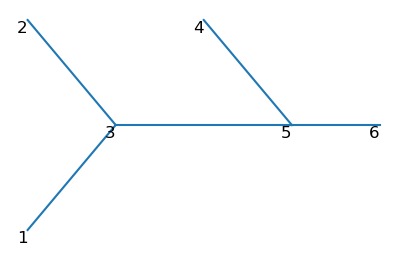

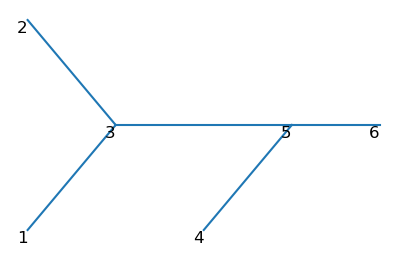

In [506]:
points_2nd_1, paths_2nd_1 = connection(points_1st_1, paths_1st_1, points_1st_1, paths_1st_1)

for i in range(len(paths_2nd_1)):
    points_2nd_1_1, paths_2nd_1_1 = simplify_diagram(points_2nd_1, paths_2nd_1[i])
    represent_diagram(points_2nd_1_1, paths_2nd_1_1, index = True)

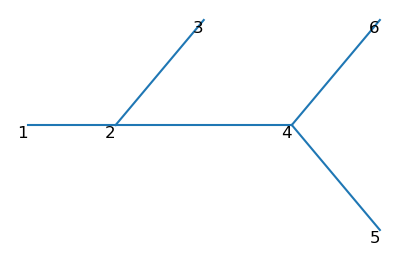

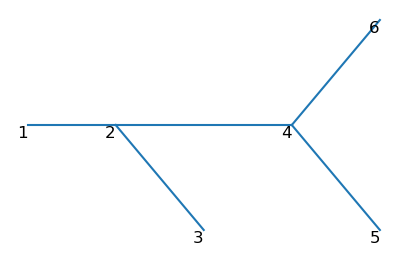

In [507]:
points_2nd_2, paths_2nd_2 = connection(points_1st_2, paths_1st_2, points_1st_2, paths_1st_2)

for i in range(len(paths_2nd_2)):
    points_2nd_2_1, paths_2nd_2_1 = simplify_diagram(points_2nd_2, paths_2nd_2[i])
    represent_diagram(points_2nd_2_1, paths_2nd_2_1, index = True)

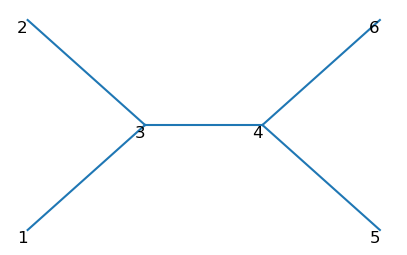

In [508]:
points_2nd_3, paths_2nd_3 = connection(points_1st_1, paths_1st_1, points_1st_2, paths_1st_2)

for i in range(len(paths_2nd_3)):
    points_2nd_3_1, paths_2nd_3_1 = simplify_diagram(points_2nd_3, paths_2nd_3[i])
    represent_diagram(points_2nd_3_1, paths_2nd_3_1, index = True)

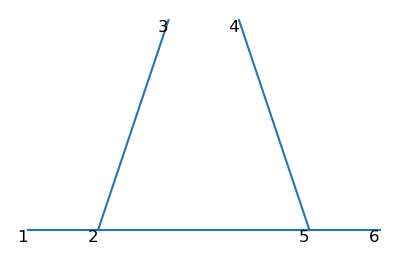

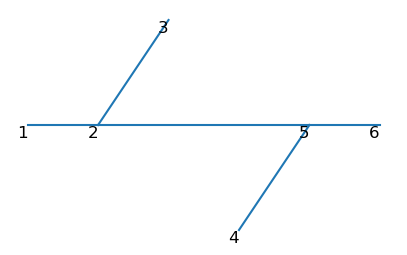

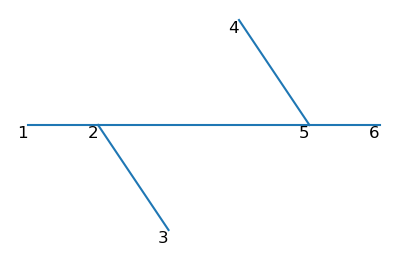

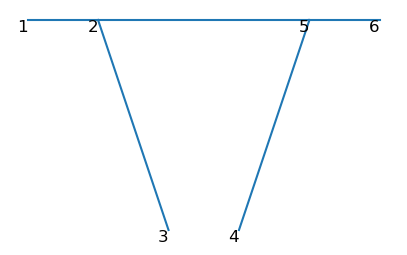

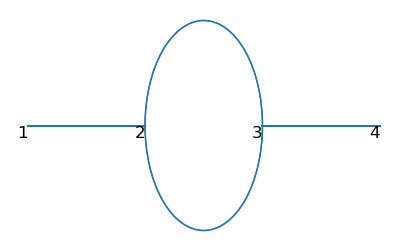

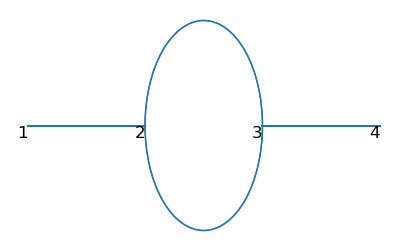

In [509]:
points_2nd_4, paths_2nd_4 = connection(points_1st_2, paths_1st_2, points_1st_1, paths_1st_1)

for i in range(len(paths_2nd_4)):
    points_2nd_4_1, paths_2nd_4_1 = simplify_diagram(points_2nd_4, paths_2nd_4[i])
    represent_diagram(points_2nd_4_1, paths_2nd_4_1, index = True)

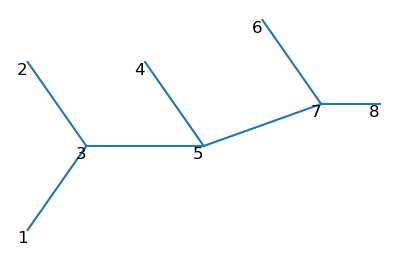

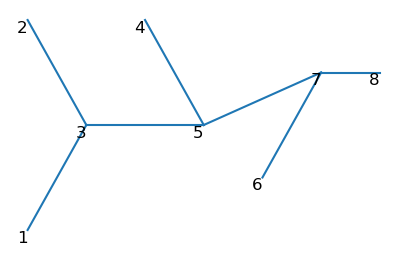

In [510]:
points_3rd_1, paths_3rd_1 = connection(points_2nd_1, paths_2nd_1[0], points_1st_1, paths_1st_1,  offset = 0.5)


for i in range(len(paths_3rd_1)):
    points_3rd_1_1, paths_3rd_1_1 = simplify_diagram(points_3rd_1, paths_3rd_1[i])
    represent_diagram(points_3rd_1_1, paths_3rd_1_1, index = True)


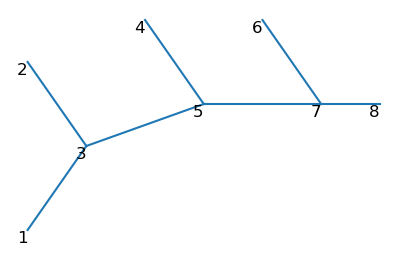

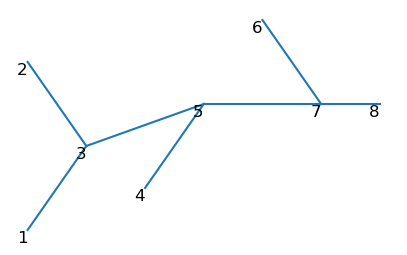

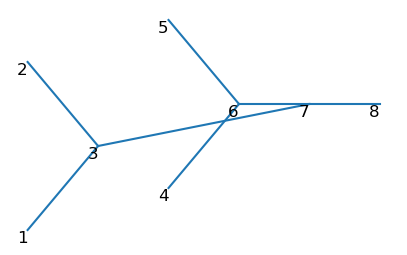

In [511]:
points_3rd_2, paths_3rd_2 = connection(points_1st_1, paths_1st_1, points_2nd_1, paths_2nd_1[0], offset = 0.5)

for i in range(len(paths_3rd_2)):
    points_3rd_2_1, paths_3rd_2_1 = simplify_diagram(points_3rd_2, paths_3rd_2[i])
    represent_diagram(points_3rd_2_1, paths_3rd_2_1, index = True)

In [512]:
points_3rd_3, paths_3rd_3 = connection(points_1st_2, paths_1st_2, points_2nd_1, paths_2nd_1[0], offset = 1)

for i in range(len(paths_3rd_3)):
    points_3rd_3_1, paths_3rd_3_1 = simplify_diagram(points_3rd_3, paths_3rd_3[i])

### Export to file

It's useful to be able to export the diagrams obtained to a file, to be able to restore later, and save some memory.

### Automatization 

Until now, we have done all the possible diagrams of the next order by hand, let's define a function that given all the diagrams of an order calculate all the diagrams of the next order.

For it, we need to store all the points in a single array, and the same for the paths. Also, we need to distinguish the canonical diagrams from the ones obtained from combining other diagrams. But let's start by the case where only first order diagrams are considered.

The `points` and `paths` passed to the function lists where
- `points`: [`points_1`, `points_2`, ...]
- `paths`: [`paths_1`, `paths_2`, ...]

where the number indicates the order of the diagram.

In [ ]:
def combine_diagrams_order (points, paths, offset = 0):
    curr_max_order = len(points)
    
    max_points = np.zeros((2), dtype=int)
    for i in range(len(paths[0])):
        n1_1 = len(np.trim_zeros(in_out_paths(paths[0][i])[0]))
        if (n1_1 > max_points[0]):
            max_points[0] = n1_1
        n2_1 = len(np.trim_zeros(in_out_paths(paths[0][i])[1]))
        if (n2_1 > max_points[1]):
            max_points[1] = n2_1

    for i in range(len(paths[-1])):
        n1_2 = len(np.trim_zeros(in_out_paths(paths[-1][i])[0]))
        if (n1_2 > max_points[0]):
            max_points[0] = n1_2
        n2_2 = len(np.trim_zeros(in_out_paths(paths[-1][i])[1]))
        if (n2_2 > max_points[1]):
            max_points[1] = n2_2

    max_connections = np.min(max_points)

    n_connections = 0
    for i in range (max_connections):
        n_connections += int(binom(max_points[0], i+1)*binom(max_points[1], i+1) * factorial(i+1))
    
    n = 0
    if len(points) == 1:
        new_points = np.zeros((2*n_connections-1, len(points[0][0]) + len(points[-1][0]), 2))
        new_paths = np.zeros((2*n_connections-1, len(paths[0][0]) + len(paths[-1][0])+max_connections, 2), dtype=int)
        for i in range(len(paths[0])): #Iterate over the len of the paths of order 1
            for j in range(len(paths[-1])): #Iterate over the len of the paths of the highest order
                dummy_points, dummy_paths = connection(points[0][i], trim_zeros_2D(paths[0][i]), points[-1][j], trim_zeros_2D(paths[-1][j]), offset=offset)
                for k in range(len(dummy_paths)):
                    simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_2D(dummy_paths[k]))
                    for l in range(len(simp_points)):
                        new_points[n, l] = simp_points[l]
                    for l in range(len(simp_paths)):
                        new_paths[n, l] = simp_paths[l]
                    n += 1
    else:
        new_points = np.zeros((2*len(paths[0])*len(paths[-1])*n_connections, len(points[0][0]) + len(points[-1][0]), 2))
        new_paths = np.zeros((2*len(paths[0])*len(paths[-1])*n_connections, len(paths[0][0]) + len(paths[-1][0])+max_connections, 2), dtype=int)
        for i in range(len(paths[0])): #Iterate over the len of the paths of order 1
            for j in range(len(paths[-1])): #Iterate over the len of the paths of the highest order
                dummy_points, dummy_paths = connection(points[0][i], trim_zeros_2D(paths[0][i]), points[-1][j], trim_zeros_2D(paths[-1][j]), offset=offset)
                for k in range(len(dummy_paths)):
                    simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_2D(dummy_paths[k]))
                    for l in range(len(simp_points)):
                        new_points[n, l] = simp_points[l]
                    for l in range(len(simp_paths)):
                        new_paths[n, l] = simp_paths[l]
                    n += 1
                dummy_points, dummy_paths = connection(points[-1][j], trim_zeros_2D(paths[-1][j]),points[0][i], trim_zeros_2D(paths[0][i]), offset=offset)
                for k in range(len(dummy_paths)):
                    simp_points, simp_paths = simplify_diagram(dummy_points, trim_zeros_2D(dummy_paths[k]))
                    for l in range(len(simp_points)):
                        new_points[n, l] = simp_points[l]
                    for l in range(len(simp_paths)):
                        new_paths[n, l] = simp_paths[l]
                    n += 1
        
    return new_points, new_paths

We will recalculate the diagrams from the start with this new method.

1452


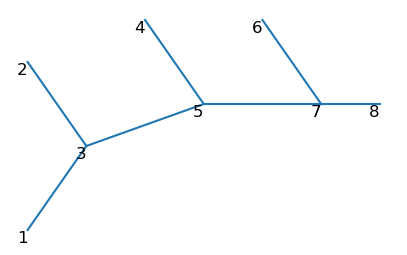

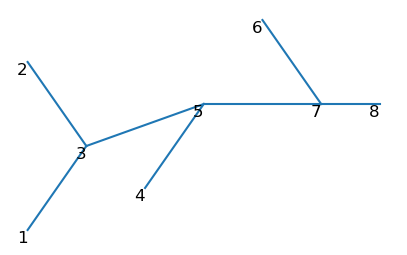

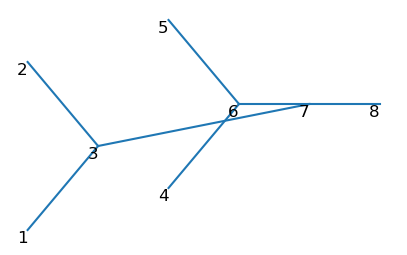

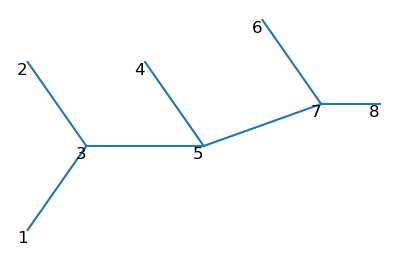

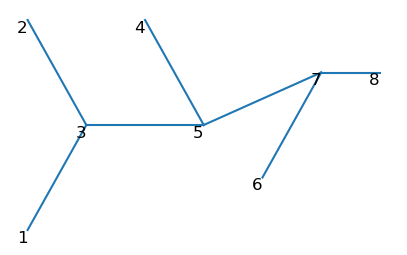

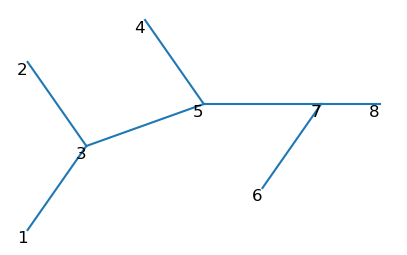

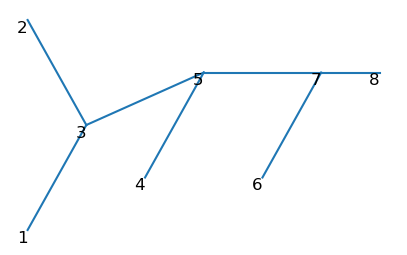

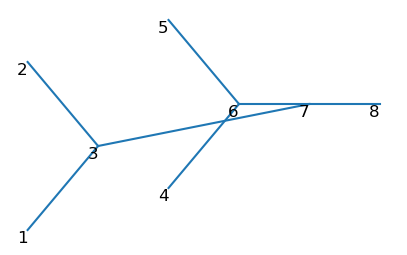

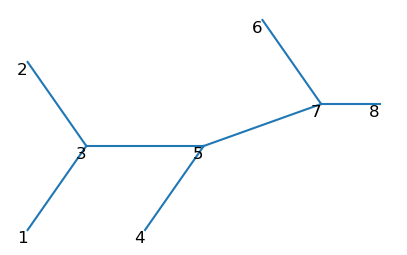

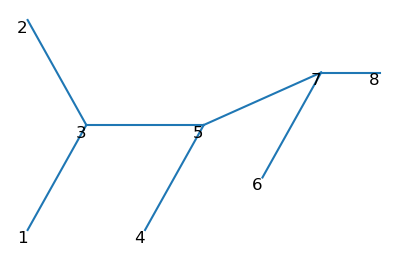

In [514]:
points_1 = np.empty((2, max(len(points_1st_1), len(points_1st_2)), 2))
points_1[0] = points_1st_1
points_1[1] = points_1st_2

paths_1 = np.empty((2, max(len(paths_1st_1), len(paths_1st_2)), 2), dtype=int)
paths_1[0] = paths_1st_1
paths_1[1] = paths_1st_2

# for i in range(len(points_1)):
#     represent_diagram(points_1[i], paths_1[i], index = True)

points_2, paths_2 = combine_diagrams_order([points_1], [paths_1], offset = 0)
# for i in range(len(paths_2)):
#     represent_diagram(points_2[i], trim_zeros_2D(paths_2[i]), index = True)

points_3, paths_3 = combine_diagrams_order([points_1, points_2], [paths_1, paths_2], offset = 0.5)
print(len(paths_3))


for i in range(len(paths_3)):
    in_out_paths_3 = in_out_paths(paths_3[i])
    if len(np.trim_zeros(in_out_paths_3[0])) == 1 and len(np.trim_zeros(in_out_paths_3[1])) == 4:
        represent_diagram(trim_zeros_2D(points_3[i]), trim_zeros_2D(paths_3[i]), index = True)


#### Group diagrams

Since we are interested in the number of diagrams that contribute the same way, it's useful to instead of outputing hundreds of diagrams, group the similar ones, output the best looking diagram, and give a counter for the number of similar ones. 

To look for similar ones, as a first test we can just look for the ones that have the exact same path array.

In [515]:
def all_components_in_other(array1, array2):
    for row1 in array1:
        found = False
        for row2 in array2:
            if np.array_equal(np.sort(row1), np.sort(row2)):
                found = True
                break
        if not found:
            return False
    return True

In [516]:
def group_diagrams (points, paths):
    group_paths = np.zeros((1, len(paths[0]), 2), dtype=int)
    group_points = np.zeros((1, len(points[0]), 2))
    group_points[0] = points[0]
    group_paths[0] = paths[0]
    count = np.zeros((1), dtype=int)
    count[0] = 1
    for i in range(1, len(paths)):
        if (paths[i] == 0).all():
            continue
        cont = False
        for j in range(len(group_paths)):
            if all_components_in_other(paths[i], group_paths[j]):
                count[j] += 1
                cont = False
                break
            else:
                cont = True

        if cont:
            group_paths = np.append(group_paths, [paths[i]], axis=0)
            group_points = np.append(group_points, [points[i]], axis=0)
            count = np.append(count, [1])
    return group_points, group_paths, count


/var/folders/nb/7jdt5d8d4r78_tr84r_d2ld80000gn/T/ipykernel_79987/2520411049.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(5,3))


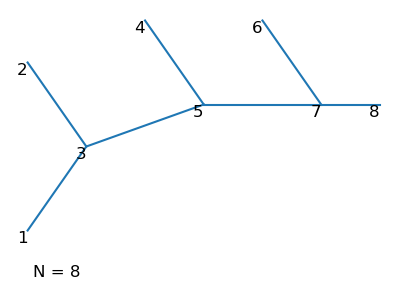

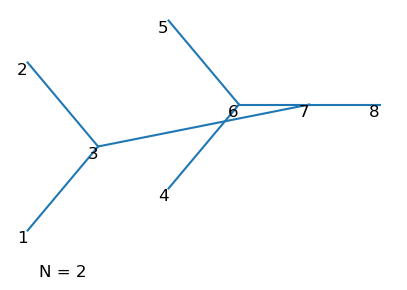

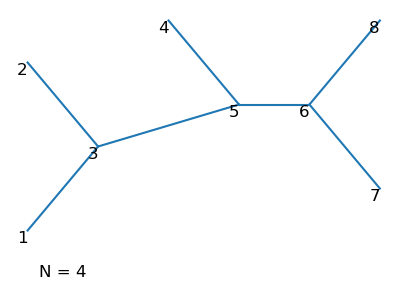

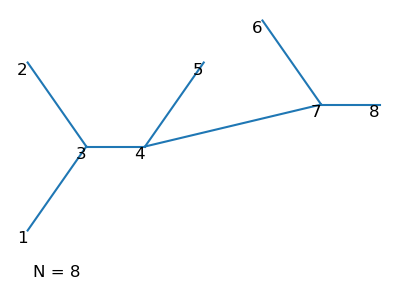

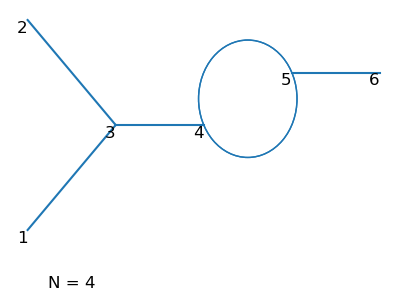

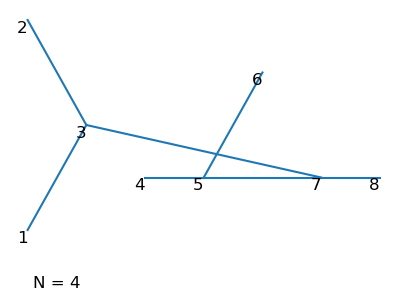

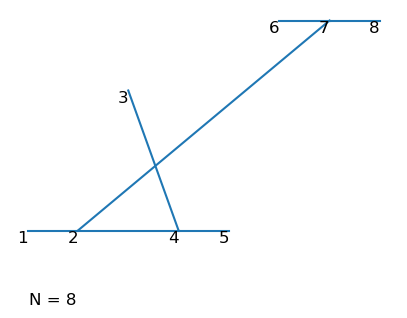

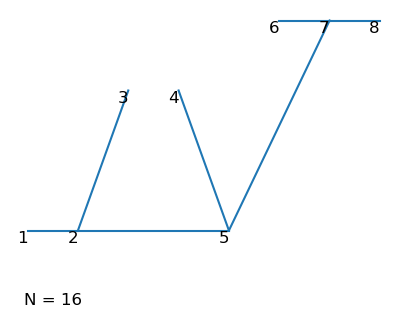

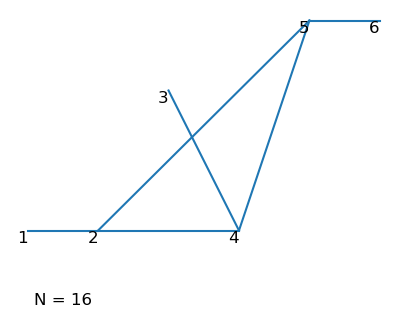

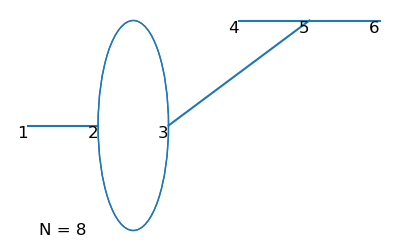

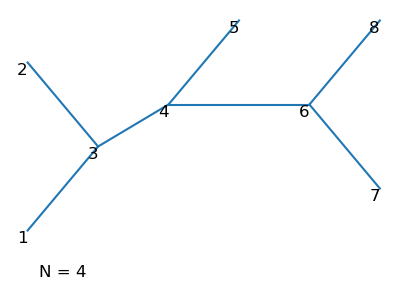

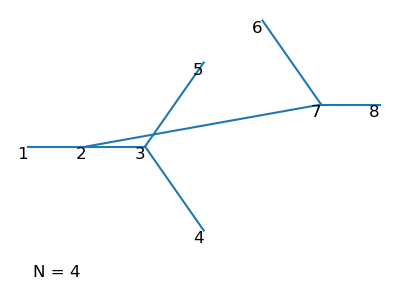

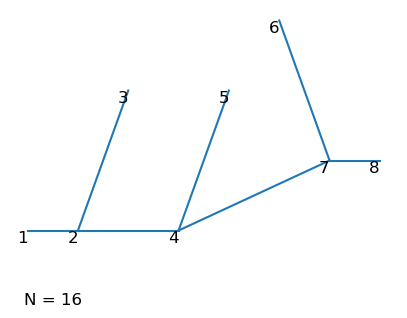

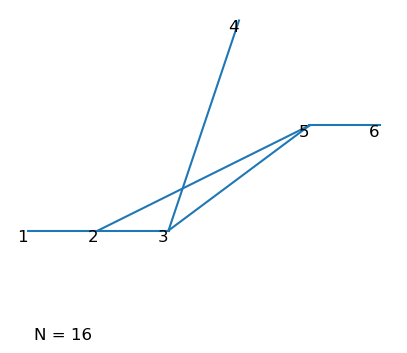

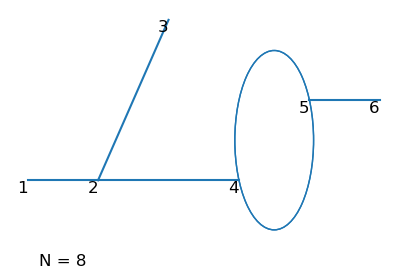

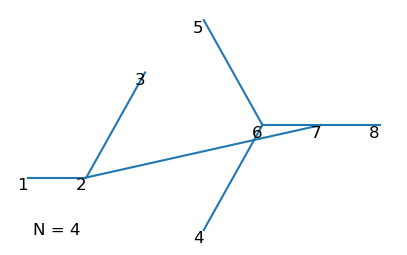

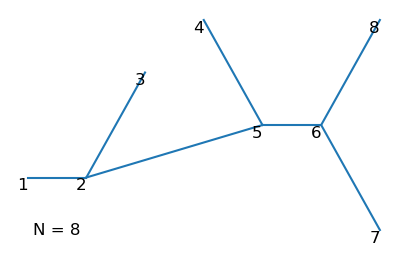

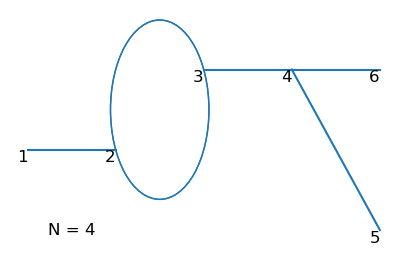

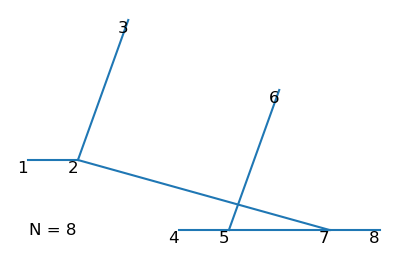

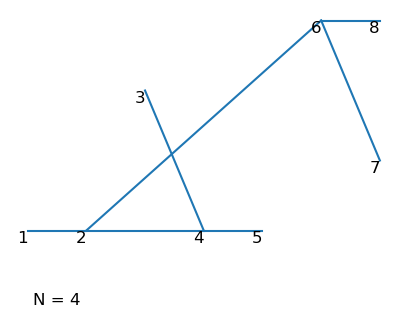

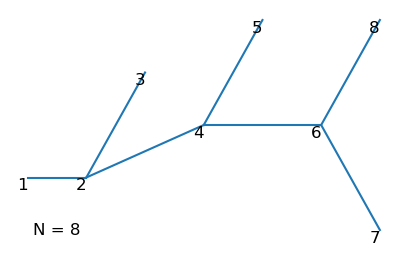

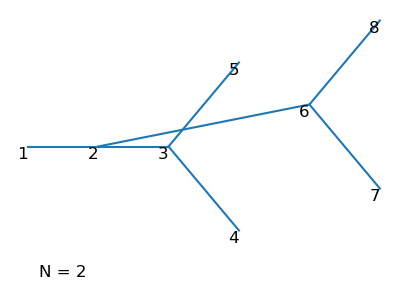

In [517]:
new_points, new_paths, count = group_diagrams(points_3, paths_3)

for i in range(len(new_paths)):
    represent_diagram(new_points[i], new_paths[i], index = True, number = count[i])


For the calculations including the canonical diagrams, we will define the canonical diagrams in the same file as the functions, this way the function can call the variables directly. But for now let's define them here. (Later these will be implemented in the multiparticle case, to take into account the instant processes.)

In [518]:
can_points_1, can_paths_1 = points_1, paths_1

can_points_2 = np.array([])

To define a diagram in terms of arrays, let's define a class that contains the information and properties of the diagram.

In [521]:
class Diagram():
    def __init__(self, points, paths):
        self.points = np.array([points])
        self.paths = np.array([paths])